In [6]:
import calibration as _cal 
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from numpy.linalg import matrix_power
from scipy.linalg import expm, expm_frechet

In [7]:
reload(_cal)

<module 'calibration' from '/home/jpmarceaux/VSProjects/CRCalibration/calibration.py'>

In [8]:
def PauliMatrix(i):
    if i == 0:
        return np.array([[1, 0], [0, 1]])
    elif i == 1:
        return np.array([[0, 1], [1, 0]])
    elif i == 2:
        return np.array([[0, -1j], [1j, 0]])
    elif i == 3:
        return np.array([[1, 0], [0, -1]])
    else:
        raise ValueError("i must be 0, 1, 2, or 3.")

def PauliTensor(i, j):
    return np.kron(PauliMatrix(i), PauliMatrix(j))

In [9]:
def modelFsim(theta, phi, chi):
    # equation 12 in https://arxiv.org/pdf/2209.11207.pdf
    return np.array([[np.exp(-1j*phi)*np.cos(theta), -1j * np.exp(1j*chi) * np.sin(theta)],
                     [-1j * np.exp(-1j*chi) * np.sin(theta), np.exp(1j*phi)*np.cos(theta)]])

def modelFsimDeriv(theta, phi, chi):
    Dtheta = np.array([[-np.exp(-1j*phi)*np.sin(theta), -1j * np.exp(1j*chi) * np.cos(theta)],
                        [-1j * np.exp(-1j*chi) * np.cos(theta), -np.exp(1j*phi)*np.sin(theta)]])
    Dphi = np.array([[-1j*np.exp(-1j*phi)*np.cos(theta), 0], 
                    [0, 1j*np.exp(1j*phi)*np.cos(theta)]])
    Dchi = np.array([[0, np.exp(1j*chi)*np.sin(theta)], 
                    [-np.exp(-1j*chi)*np.sin(theta), 0]])
    return np.array([Dtheta, Dphi, Dchi])

In [10]:
PREP_DICT = {
    '0' : np.array([[1], [0]]),
    '1' : np.array([[0], [1]]),
    '+': np.array([[1], [1]])/np.sqrt(2),
    '-': np.array([[1], [-1]])/np.sqrt(2),
    'r': np.array([[1], [1j]])/np.sqrt(2),
    'l': np.array([[1], [-1j]])/np.sqrt(2),
}
MEAS_DICT = {
    '0' : np.array([[1, 0]]),
    '1' : np.array([[0, 1]]),
    '+': np.array([[1, 1]])/np.sqrt(2),
    '-': np.array([[1, -1]])/np.sqrt(2),
    'r': np.array([[1, -1j]])/np.sqrt(2),
    'l': np.array([[1, 1j]])/np.sqrt(2),
}

In [6]:
def probability(xstate, d, circ_def):
    Fsim = modelFsim(*xstate)
    prep, meas, omega = circ_def
    S = expm(-1j * omega * PauliMatrix(3))
    Fsim = modelFsim(*xstate)
    meas = MEAS_DICT[meas]
    prep = PREP_DICT[prep]
    probs = np.abs(meas@matrix_power(S@Fsim, d)@S@prep)**2
    # assert imaginary part is zero
    assert np.allclose(np.imag(probs), 0)
    return probs.real

def sp_prod_grad(xstate, d, omega):
    S = expm(-1j * omega * PauliMatrix(3))
    Fsim = modelFsim(*xstate)
    FsimDeriv = modelFsimDeriv(*xstate)
    grad = np.zeros(FsimDeriv.shape, dtype=np.complex128)
    for i in range(len(xstate)):
        for j in range(d):
            grad[i] += matrix_power(S@Fsim, j)@S@FsimDeriv[i]@matrix_power(S@Fsim, d-j-1)@S
    return grad

def probability_gradient(xstate, d, circ_def):
    Fsim = modelFsim(*xstate)
    prob_grads = np.zeros((1, len(xstate)), dtype=np.complex128)
    prep, meas, omega = circ_def
    S = expm(-1j * omega * PauliMatrix(3))
    grad = sp_prod_grad(xstate, d, omega)
    sp_prod = matrix_power(S@Fsim, d)@S
    prep = PREP_DICT[prep]
    meas = MEAS_DICT[meas]
    for k in range(len(xstate)):
        prob_grads[0, k] = meas@sp_prod@prep * np.conjugate(meas@grad[k]@prep) + \
                            meas@grad[k]@prep * np.conjugate(meas@sp_prod@prep)
    # assert imaginary part is zero
    assert np.allclose(np.imag(prob_grads), 0)
    return np.real(prob_grads)



In [7]:
def edesign_probability(xstate, d, circ_defs):
    Fsim = modelFsim(*xstate)
    probs = np.zeros(len(circ_defs))
    for idx, (prep, meas, omega) in enumerate(circ_defs):
        probs[idx] = probability(xstate, d, circ_defs[idx])
    return probs

def edesign_probability_gradient(xstate, d, circ_defs):
    prob_grads = np.zeros((len(circ_defs), len(xstate)), dtype=np.complex128)
    for idx, (prep, meas, omega) in enumerate(circ_defs):
        prob_grads[idx] = probability_gradient(xstate, d, circ_defs[idx])
    return prob_grads

In [8]:
def circuit_fisher_matrix(xstate, d, circ_def):
    prob = probability(xstate, d, circ_def)
    prob_grads = probability_gradient(xstate, d, circ_def)
    if prob == 0:
        return np.zeros((len(xstate), len(xstate)))
    else:
        return (1/prob) * np.outer(prob_grads, prob_grads)

def edesign_fisher_matrix(xstate, d, circ_defs):
    total_fisher_matrix = np.zeros((len(xstate), len(xstate)))
    for circ_def in circ_defs:
        total_fisher_matrix += circuit_fisher_matrix(xstate, d, circ_def)
    return total_fisher_matrix

In [9]:
def original_edesign(omega):
    return (
        [('+', '0', omega), 
         ('r', '0', omega)]
    )

In [35]:
edesign_fisher_matrix(np.array([np.pi/2, 0, 0]), 1, original_edesign(0.6))

array([[2.00000000e+00, 6.16297582e-33, 6.16297582e-33],
       [6.16297582e-33, 7.49879891e-33, 7.49879891e-33],
       [6.16297582e-33, 7.49879891e-33, 7.49879891e-33]])

In [11]:
def score_fisher_matrix(fmat):
    eigvals= np.linalg.eigvals(fmat)
    eigvals = np.clip(eigvals, 10**-40, None)
    return np.sum(np.log(eigvals))

def find_optimal_edesign(num_circs, xstate, d, all_circs):
    total_fisher_mat = np.zeros((len(xstate), len(xstate)))
    all_fisher_mats = [circuit_fisher_matrix(xstate, d, circ_def) for circ_def in all_circs]
    optimal_circs = []
    for i in range(num_circs):
        best_score = -np.inf
        best_idx = None
        for j in range(len(all_circs)):
            if all_circs[j] not in optimal_circs:
                score = score_fisher_matrix(total_fisher_mat + all_fisher_mats[j])
                if score > best_score:
                    best_score = score
                    best_idx = j
        total_fisher_mat += all_fisher_mats[best_idx]
        optimal_circs.append(all_circs[best_idx])
    return optimal_circs

In [13]:
def edesign_observation(xstate, d, edesign, num_shots):
    probs = edesign_probability(xstate, d, edesign)
    return np.array([np.random.binomial(num_shots, probs[i])/num_shots for i in range(len(edesign))])

In [14]:
from scipy.stats import multivariate_normal

In [15]:
class KalmanFilter:
    def __init__(self, xinitial, Pinitial, Q=None, record_history=True) -> None:
        self.x = xinitial
        self.P = Pinitial
        if Q is None:
            self.Q = np.zeros((len(xinitial), len(xinitial)))
        else:
            self.Q = Q
        if record_history:
            self.history = {'x': [self.x], 'P': [self.P]}

    def predict(self):
        # TODO : implmenet controls
        self.x = self.x
        self.P = self.P + self.Q

    def update(self, observation, d, circ_defs, R, iterative=False, max_iter=100, tol=1e-6):
        if not iterative:
            jacobian = edesign_probability_gradient(self.x, d, circ_defs)
            prediction = edesign_probability_gradient(self.x, d, circ_defs)
            S = jacobian@self.P@jacobian.T + R
            K = self.P@jacobian.T@np.linalg.inv(S)
            self.x = self.x + K@(observation - prediction)
            print(self.x)
            self.P = self.P - K@jacobian@self.P
        elif iterative:
            for i in range(max_iter):
                jacobian = edesign_probability_gradient(self.x, d, circ_defs)
                prediction = edesign_probability(self.x, d, circ_defs)
                S = jacobian@self.P@jacobian.T + R
                K = self.P@jacobian.T@np.linalg.inv(S)
                self.x = self.x + K@(observation - prediction)
                if np.linalg.norm(K@(observation - prediction)) < tol:
                    break
            self.P = self.P - K@jacobian@self.P
        else: 
            raise ValueError("iterative must be True or False")
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)

    def plot_rms_history(self, xtrue, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        rms_history = np.zeros(len(self.history['x']))
        for idx, x in enumerate(self.history['x']):
            rms_history[idx] = np.linalg.norm(x - xtrue)
        ax.plot(rms_history)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMS Error')

    def plot_expected_innovations(self, edesign, xtrue, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ds = list(edesign.keys())
        num_circ_defs = len(edesign[ds[0]])
        innovations = np.zeros((num_circ_defs, len(ds)))
        for idx, d in enumerate(ds):
            innovations[:, idx] = edesign_probability(xtrue, d, edesign[d]) - edesign_probability(self.x, d, edesign[d])
        ax.plot(ds, innovations.T)
        ax.set_xlabel('Depth')
        ax.set_ylabel('Innovation')

    def run(self, observations, d, circ_defs, R):
        for observation in observations:
            self.predict()
            self.update(observation, d, circ_defs, R)
            if hasattr(self, 'history'):
                self.history['x'].append(self.x)
                self.history['P'].append(self.P)
        return self.x, self.P

In [25]:
def R_worst_case(num_circ_defs, num_shots):
    return (0.25/num_shots)*np.eye(num_circ_defs)

def depth_function(Pcovar):
    return 1+int(0.5/np.sqrt(np.trace(Pcovar)))

In [26]:
inital_error = np.linalg.norm(xinitial - state0)
inital_error

1.1370938416283942

In [27]:
from tqdm import tqdm

In [28]:
num_updates = 4
num_iterations = 100
iteration_eps = 1e-4
num_depths = 8

In [29]:
num_omega = 4
all_circs = [(p, m, omega) for p in PREP_DICT for m in MEAS_DICT for omega in np.linspace(0, 2*np.pi, num_omega)]
edesign = find_optimal_edesign(4, np.array([np.pi/2+0.1, 0, 0]), 4, all_circs)

In [30]:
state0 = np.array([0.01, 0.2, 0.4])
num_circ_defs = 10
Pinitial = (1/3)*np.eye(3)
xinitial = np.random.multivariate_normal(state0, Pinitial)
num_shots = 1000
num_circ_defs = 2
R = R_worst_case(len(all_circs), num_shots)

In [31]:
kf = KalmanFilter(xinitial, Pinitial, record_history=True)
total_edesign = []
observation = np.array([])
for i in tqdm(range(num_depths)):
    d = depth_function(kf.P)
    print(d)
    edesign = all_circs
    observation = edesign_observation(state0, d, edesign, num_shots)
    R = R_worst_case(len(all_circs), num_shots)
    kf.update(observation, d, edesign, R, iterative=True, max_iter=num_iterations, tol=iteration_eps)

  0%|          | 0/8 [00:00<?, ?it/s]

1


 12%|█▎        | 1/8 [00:00<00:06,  1.08it/s]/tmp/ipykernel_4583/419912228.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return 1+int(0.5/np.sqrt(np.trace(Pcovar)))


3


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

5


 38%|███▊      | 3/8 [00:02<00:04,  1.01it/s]

7


 50%|█████     | 4/8 [00:04<00:05,  1.36s/it]

10


 62%|██████▎   | 5/8 [00:08<00:06,  2.09s/it]

12


 75%|███████▌  | 6/8 [00:17<00:09,  4.70s/it]

13


 88%|████████▊ | 7/8 [00:31<00:07,  7.53s/it]

13


100%|██████████| 8/8 [00:34<00:00,  4.27s/it]


In [32]:
1/d

0.07692307692307693

In [33]:
final_error = np.linalg.norm(kf.x - state0)
final_error

0.05453775120379759

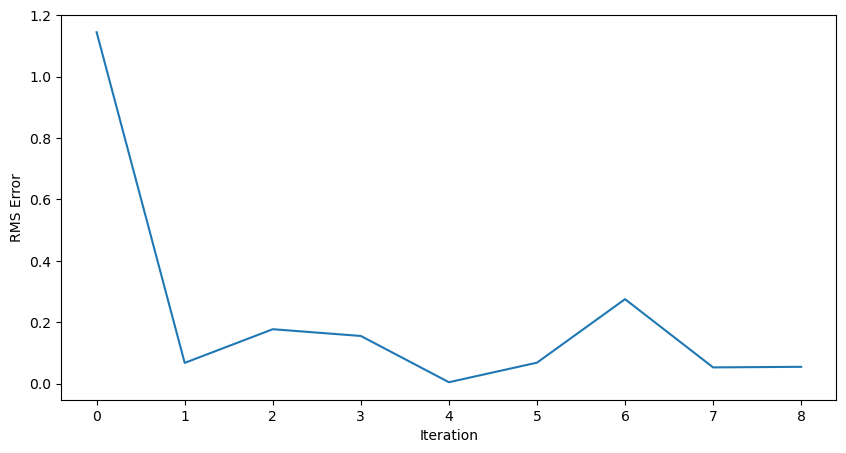

In [34]:
kf.plot_rms_history(state0)

In [554]:
from scipy.linalg import sqrtm

In [555]:
1/np.sqrt(np.trace(kf.P))

(25.633177572988032+0j)

In [556]:
1/np.trace(sqrtm(kf.P))

(25.300216835089854521+0j)

In [557]:
2**8

256

In [558]:
1/2**8

0.00390625

In [559]:
kf.x

array([0.0093324 +0.j, 0.19978712+0.j, 0.48143751+0.j])

In [560]:
state0

array([0.01, 0.2 , 0.4 ])